In [2]:
! pip install numpy
! pip install pandas
! pip install seaborn
! pip install scikit-learn
! pip install matplotlib
! pip install tensorflow
! pip install keras
! pip install sgp4
! pip install scipy

! pip install openpyxl


  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   - -------------------------------------- 13.1/375.9 MB 68.7 MB/s eta 0:00:06
   -- ------------------------------------- 27.0/375.9 MB 65.9 MB/s eta 0:00:06
   ---- ----------------------------------- 39.6/375.9 MB 64.6 MB/s eta 0:00:06
   ---- ----------------------------------- 46.7/375.9 MB 55.0 MB/s eta 0:00:06
   ----- ---------------------------------- 56.1/375.9 MB 51.8 MB/s eta 0:00:07
   ------ --------------------------------- 64.2/375.9 MB 49.3 MB/s eta 0:00:07
   ------- -------------------------------- 69.5/375.9 MB 46.1 

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sgp4.api import Satrec
from scipy.spatial.transform import Rotation as R

# TLE da ISS
line1 = "1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992"
line2 = "2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959"
sat = Satrec.twoline2rv(line1, line2)

# Função auxiliar
def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4) \
         + int((275 * month) / 9) + day + 1721013.5 \
         + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr

# Parâmetros
base_time = datetime.utcnow()
intervalo_segundos = 30
samples = 200
tempos, q0, q1, q2, q3 = [], [], [], [], []
rolls, pitchs, yaws = [], [], []

# Loop de propagação
for i in range(samples):
    dt = base_time + timedelta(seconds=i * intervalo_segundos)
    jd, fr = datetime_to_julian_date(dt)
    err, position, velocity = sat.sgp4(jd, fr)

    if err != 0:
        print(f"Erro na propagação para t={dt}, código: {err}")
        continue

    r = np.array(position)
    v = np.array(velocity)

    z = -r / np.linalg.norm(r)
    y = np.cross(z, v); y /= np.linalg.norm(y)
    x = np.cross(y, z)
    rot_matrix = np.vstack([x, y, z]).T
    rotation = R.from_matrix(rot_matrix)

    quat = rotation.as_quat()   # x, y, z, w
    euler = rotation.as_euler('xyz', degrees=True)

    tempos.append(i * intervalo_segundos)
    q0.append(quat[3]); q1.append(quat[0]); q2.append(quat[1]); q3.append(quat[2])
    rolls.append(euler[0]); pitchs.append(euler[1]); yaws.append(euler[2])

# Rotulagem automática
def rotular_gimbal_lock(pitch, tolerancia=2):
    if abs(pitch - 90) < tolerancia:
        return "gimbal_lock"
    elif abs(pitch - 90) < tolerancia + 5:
        return "alerta"
    else:
        return "ok"

# DataFrame final
df = pd.DataFrame({
    'tempo': tempos,
    'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3,
    'roll': rolls,
    'pitch': pitchs,
    'yaw': yaws
})
df['status'] = df['pitch'].apply(rotular_gimbal_lock)

print(df.head())
df.to_excel("dados_orientacao_IA.xlsx", index=False) # visualização


   tempo        q0        q1        q2        q3       roll      pitch  \
0      0 -0.157776 -0.047356 -0.343858  0.924460 -39.280019  11.306784   
1     30 -0.169356 -0.015817 -0.338286  0.925544 -38.855986   8.271310   
2     60 -0.180738  0.015738 -0.332321  0.925553 -38.567533   5.220758   
3     90 -0.191909  0.047274 -0.325970  0.924489 -38.411004   2.160878   
4    120 -0.202857  0.078754 -0.319242  0.922351 -38.384417  -0.902787   

          yaw status  
0 -164.675995     ok  
1 -162.183245     ok  
2 -159.728904     ok  
3 -157.298517     ok  
4 -154.878007     ok  


Matplotlib is building the font cache; this may take a moment.


Distribuição dos rótulos gerados:
 status
ok             210
gimbal_lock     10
alerta          10
Name: count, dtype: int64
Rótulos codificados: ['alerta' 'gimbal_lock' 'ok']


c:\Users\jaysa.gabrielly\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.8213 - loss: 0.6882 - val_accuracy: 0.8889 - val_loss: 0.4621
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9062 - loss: 0.3681 - val_accuracy: 0.8889 - val_loss: 0.2888
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9264 - loss: 0.2175 - val_accuracy: 0.9167 - val_loss: 0.2184
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9712 - loss: 0.1208 - val_accuracy: 0.9444 - val_loss: 0.1938
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9726 - loss: 0.1125 - val_accuracy: 0.9444 - val_loss: 0.1787
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9817 - loss: 0.0874 - val_accuracy: 0.9444 - val_loss: 0.1665
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9841 - loss: 0.0677 - val_accuracy: 0.9444 - val_loss: 0.1540
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9819 - loss: 0.0616 - val_accuracy: 0.9444 - val_loss: 0.1450

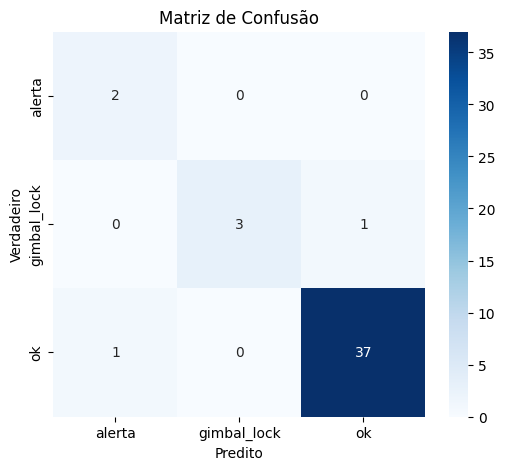

Relatório de Classificação:

              precision    recall  f1-score   support

      alerta       0.67      1.00      0.80         2
 gimbal_lock       1.00      0.75      0.86         4
          ok       0.97      0.97      0.97        38

    accuracy                           0.95        44
   macro avg       0.88      0.91      0.88        44
weighted avg       0.96      0.95      0.96        44


Exemplo de previsões para novas sequências:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Amostra 1: Classe prevista = ok, Probabilidades = [1.4742484e-04 2.9310839e-05 9.9982327e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Amostra 2: Classe prevista = ok, Probabilidades = [8.6298729e-05 2.3371142e-05 9.9989033e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Amostra 3: Classe prevista = ok, Probabilidades = [1.1158644e-04 9.1187110e-05 9.9979728e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Amostra 4: Classe prevista = ok, Probabilidades = [1.3105391e-04 1.1764988e-04 9.9975127e-01]
1/1 ━━━━━━━━━

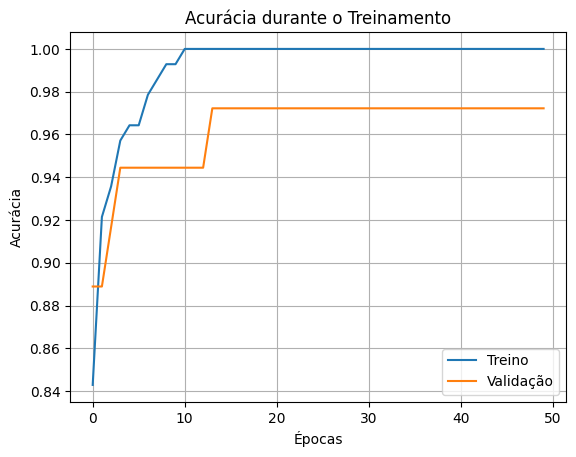

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df = pd.read_excel("dados_orientacao_IA.xlsx")

# Rótulo automático com base no pitch
def rotulo(pitch):
    if abs(pitch - 90) < 2:
        return 'gimbal_lock'
    elif abs(pitch - 90) < 7:
        return 'alerta'
    else:
        return 'ok'

df['status'] = df['pitch'].apply(rotulo)

# Dados sintéticos de alerta e gimbal_lock
df_fake = pd.DataFrame({
    'tempo': range(30),
    'q0': np.random.uniform(-1, 1, 30),
    'q1': np.random.uniform(-1, 1, 30),
    'q2': np.random.uniform(-1, 1, 30),
    'q3': np.random.uniform(-1, 1, 30),
    'roll': np.random.uniform(-180, 180, 30),
    'pitch': np.concatenate([
        np.full(10, 90),     # gimbal_lock
        np.full(10, 88),     # alerta (|pitch - 90| = 2)
        np.full(10, 100)     # ok (|pitch - 90| = 10)
    ]),
    'yaw': np.random.uniform(-180, 180, 30)
})

df_fake['status'] = df_fake['pitch'].apply(rotulo)

# Junta os dados
df = pd.concat([df, df_fake], ignore_index=True)



# Codifica os rótulos
encoder = LabelEncoder()
y_raw = encoder.fit_transform(df['status'])
print("Distribuição dos rótulos gerados:\n", df['status'].value_counts())
print("Rótulos codificados:", encoder.classes_)

# Seleciona as features e define janela
features = ['q0', 'q1', 'q2', 'q3', 'roll', 'pitch', 'yaw']
window_size = 10

X, y = [], []
for i in range(len(df) - window_size):
    seq_x = df[features].iloc[i:i+window_size].values
    label = y_raw[i + window_size]
    X.append(seq_x)
    y.append(label)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, len(features))))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Avaliação
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Acurácia: {acc:.2f} | Loss: {loss:.4f}")

# ---------- Mtriz de Confusão ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Fazer previsões no conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# 2. Matriz
cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_  # classes originais ['gimbal_lock', 'ok', 'alerta'] por exemplo

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão")
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# 3. Relatório de Classificação
print("Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# 4. Testar previsão em novas amostras (exemplo: últimas sequências do conjunto de teste)
print("\nExemplo de previsões para novas sequências:\n")
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    print(f"Amostra {i+1}: Classe prevista = {pred_class}, Probabilidades = {pred_prob}")
# --------------------------------------

# Visualização
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# para salvar os dados
# extensão: H5Web
from tensorflow.keras.models import load_model
model.save("modelo_gimbal_lock.h5")

# model = load_model("modelo_gimbal_lock.h5")

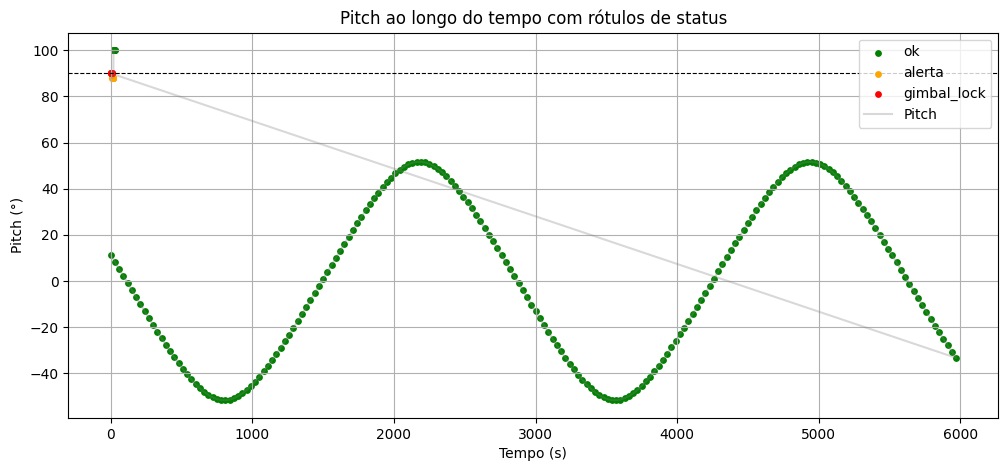

In [6]:
import matplotlib.pyplot as plt

cores = {'ok': 'green', 'alerta': 'orange', 'gimbal_lock': 'red'}

plt.figure(figsize=(12, 5))
for status, cor in cores.items():
    subset = df[df['status'] == status]
    plt.scatter(subset['tempo'], subset['pitch'], label=status, color=cor, s=15)

plt.plot(df['tempo'], df['pitch'], color='gray', alpha=0.3, label='Pitch')
plt.axhline(90, color='black', linestyle='--', linewidth=0.8)
plt.title("Pitch ao longo do tempo com rótulos de status")
plt.xlabel("Tempo (s)")
plt.ylabel("Pitch (°)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    
    print(f"\n🛰️ Amostra {i+1} - Classe prevista: {pred_class}")
    print(f"Probabilidades: {pred_prob}")
    print("Sequência de pitchs:")
    print(X_test[i][:, features.index('pitch')])  # extrai os valores de pitch da sequência

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

🛰️ Amostra 1 - Classe prevista: ok
Probabilidades: [1.4742484e-04 2.9310839e-05 9.9982327e-01]
Sequência de pitchs:
[-28.77712712 -25.9726577  -23.10564668 -20.18627715 -17.22355183
 -14.22550457 -11.19938905  -8.15184697  -5.08905872  -2.01688036]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

🛰️ Amostra 2 - Classe prevista: ok
Probabilidades: [8.6298729e-05 2.3371142e-05 9.9989033e-01]
Sequência de pitchs:
[19.27044979 22.20507133 25.09032754 27.9164044  30.67214567 33.34479723
 35.91975781 38.38031691 40.70743961 42.87963861]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

🛰️ Amostra 3 - Classe prevista: ok
Probabilidades: [1.1158644e-04 9.1187110e-05 9.9979728e-01]
Sequência de pitchs:
[  8.15099081   5.09995335   2.03980932  -1.02390229  -4.08572173
  -7.14015115 -10.18153603 -13.20394175 -16.20102141 -19.1658713 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

🛰️ Amostra 4 - Classe prevista: ok
Probabilidades: [1.3105391e-04 1.1764988e-04 9.9975127e-01]
Sequência

In [8]:
print(f"\n🔎 Avaliação Final:")
print(f"Acurácia: {acc:.2f} | Loss: {loss:.4f}")
print("\nMatriz de Confusão e Classificação:")
print(classification_report(y_true, y_pred, target_names=labels))


🔎 Avaliação Final:
Acurácia: 0.95 | Loss: 0.3302

Matriz de Confusão e Classificação:
              precision    recall  f1-score   support

      alerta       0.67      1.00      0.80         2
 gimbal_lock       1.00      0.75      0.86         4
          ok       0.97      0.97      0.97        38

    accuracy                           0.95        44
   macro avg       0.88      0.91      0.88        44
weighted avg       0.96      0.95      0.96        44

